# Tweet Sentiment Analysis
---

In [326]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import os

#Import WordCloud
from wordcloud import WordCloud, STOPWORDS
from scipy import stats

In [105]:
# Remove unwanted patterns
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chiehhsi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chiehhsi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [106]:
#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

In [212]:
def load_csv():
    xls = pd.ExcelFile('training-Obama-Romney-tweets.xlsx')
    df1 = pd.read_excel(xls, 'Obama')
    df2 = pd.read_excel(xls, 'Romney')
    return df1, df2

def data_parse(df):
    
    #drop missing values and rename columns
    df = df.iloc[1:, 3:5]
    df = df.rename(columns = {'Anootated tweet':'Tweet', 'Unnamed: 4': 'Class'})
    # Drop rows if Tweet is empty
    df.dropna(subset = ['Tweet'], inplace=True)
    print(df.shape)
    
    #dtype class label
    df['Class'] = df['Class'].astype(str)
    df['Tweet'] = df['Tweet'].astype(str)
    print(df.info())
    print(df['Class'].value_counts())

    # Extract rows where class labels -1, 0, 1
    df = df[ (df['Class'] == '0') |(df['Class'] == '-1') | (df['Class'] == '1') ]
    print('After extracting:', df.shape)
    
    tweets = df['Tweet'].values
    targets = df['Class'].values
    
    return tweets, targets

In [369]:
# Tweet Cleaner
stopwordlist = set(stopwords.words("english"))
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def remove_stopwords(tweet):
    new_tweet = [w for w in tweet.split() if not w in stopwordlist] 
    return (" ").join(new_tweet) 

def remove_specialchar(tweet):
    #Converts HTML tags to the characters they represent
    soup = BeautifulSoup(tweet, "html.parser")
    tweet = soup.get_text()
    
    #Convert www.* or https?://* to empty strings
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) 
    #Convert @username to empty strings
    tweet = re.sub('@[^\s]+','',tweet)

    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('[\n]+', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #Trims the tweet
    tweet = tweet.strip('\'"')
    
    #Remove all char not alphabets, num or whitespaces
    tweet = re.sub('[^A-Za-z0-9 ]+','', tweet)
    
    # Match all digits in the string and replace them by empty string
    pattern = r'[0-9]'
    tweet = re.sub(pattern, '', tweet)
    
    return tweet

#Replace words in abbr_dict, short_word_dict
def replace_words(s, words=abbr_dict):
    for k, v in words.items():
        s = s.replace(k, v)
    return s


#Attempts to replace every individual word with it's root word.
def stemmer_lemmatizer(tweet):
    word_list = []
    for word in tweet.split():
        word = ps.stem(word)
        word = wordnet_lemmatizer.lemmatize(word)
        word_list.append(word)
    return (" ".join(word_list))

#for testing
#Tweets = df_oba['Tweet'].values
#for i in range(len(Tweets)):
#    print(i)
#    b = remove_specialchar(Tweets[i])
#    a = stemmer_lemmatizer(b)
#    print('last', a)
#    print('last', remove_stopwords(a))


In [370]:
def tweet_cleaning(tweets, flag):
    
    for i in range(len(tweets)):
        #print(i)
        #print('original:', tweets[i])
        tweets[i] = tweets[i].lower()
        replace_words(tweets[i])
        tweets[i] = remove_specialchar(tweets[i])
        
        if flag == 'stem_lem':
            tweets[i] = stemmer_lemmatizer(tweets[i])
        if flag == 'rm_stopwords':
            tweets[i] = remove_stopwords(tweets[i])
        if flag == 'all':
            tmp = stemmer_lemmatizer(tweets[i])
            tweets[i] = remove_stopwords(tmp)
        #tmp = remove_specialchar(tweets[i])
        #tmp = stemmer_lemmatizer(tmp)
        #tweets[i] = remove_stopwords(tmp)
        #print('final:', tweets[i])
    return tweets

In [462]:
Tweets = tweets_oba
for i in range(len(Tweets)):
    #print(Tweets[i])
    #a = re.sub('[^A-Za-z0-9 ]+','', Tweets[i])
    a = remove_digits(Tweets[i])
#    b = remove_specialchar(Tweets[i])
#    a = stemmer_lemmatizer(b)
    #print('last', a)
#    print('last', remove_stopwords(a))



In [367]:
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",
    
    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    #punctuation:'',
    '\s+':' ', # replace multi space with one single space
    "121": "one to one",
    "a/s/l": "age, sex, location",
    "adn": "any day now",
    "afaik": "as far as I know",
    "afk": "away from keyboard",
    "aight": "alright",
    "alol": "actually laughing out loud",
    "b4": "before",
    "b4n": "bye for now",
    "bak": "back at the keyboard",
    "bf": "boyfriend",
    "bff": "best friends forever",
    "bfn": "bye for now",
    "bg": "big grin",
    "bta": "but then again",
    "btw": "by the way",
    "cid": "crying in disgrace",
    "cnp": "continued in my next post",
    "cp": "chat post",
    "cu": "see you",
    "cul": "see you later",
    "cul8r": "see you later",
    "cya": "bye",
    "cyo": "see you online",
    "dbau": "doing business as usual",
    "fud": "fear, uncertainty, and doubt",
    "fwiw": "for what it's worth",
    "fyi": "for your information",
    "g": "grin",
    "g2g": "got to go",
    "ga": "go ahead",
    "gal": "get a life",
    "gf": "girlfriend",
    "gfn": "gone for now",
    "gmbo": "giggling my butt off",
    "gmta": "great minds think alike",
    "h8": "hate",
    "hagn": "have a good night",
    "hdop": "help delete online predators",
    "hhis": "hanging head in shame",
    "iac": "in any case",
    "ianal": "I am not a lawyer",
    "ic": "I see",
    "idk": "I don't know",
    "imao": "in my arrogant opinion",
    "imnsho": "in my not so humble opinion",
    "imo": "in my opinion",
    "iow": "in other words",
    "ipn": "I’m posting naked",
    "irl": "in real life",
    "jk": "just kidding",
    "l8r": "later",
    "ld": "later, dude",
    "ldr": "long distance relationship",
    "llta": "lots and lots of thunderous applause",
    "lmao": "laugh my ass off",
    "lmirl": "let's meet in real life",
    "lol": "laugh out loud",
    "ltr": "longterm relationship",
    "lulab": "love you like a brother",
    "lulas": "love you like a sister",
    "luv": "love",
    "m/f": "male or female",
    "m8": "mate",
    "milf": "mother I would like to fuck",
    "oll": "online love",
    "omg": "oh my god",
    "otoh": "on the other hand",
    "pir": "parent in room",
    "ppl": "people",
    "r": "are",
    "rofl": "roll on the floor laughing",
    "rpg": "role playing games",
    "ru": "are you",
    "shid": "slaps head in disgust",
    "somy": "sick of me yet",
    "sot": "short of time",
    "thanx": "thanks",
    "thx": "thanks",
    "ttyl": "talk to you later",
    "u": "you",
    "ur": "you are",
    "uw": "you’re welcome",
    "wb": "welcome back",
    "wfm": "works for me",
    "wibni": "wouldn't it be nice if",
    "wtf": "what the fuck",
    "wtg": "way to go",
    "wtgp": "want to go private",
    "ym": "young man",
    "gr8": "great"
}

In [153]:
tweets_oba[10]

'obama prioriti 30k gaydar research secur embassi libya tlot tcot p2'

In [128]:
def save_dataset(tweets, targets, tw_name, tar_name):
    print('Saving training dataset...')
    
    #Create Saving Files
    if not os.path.exists('TrainData'):
        os.makedirs('TrainData')
        
    np.save('TrainData/' + tw_name + '.npy', tweets)
    np.save('TrainData/' + tar_name + '.npy', targets)

    print('Saved parsed dataset')
    

In [129]:
def wordcloud(data,backgroundcolor = 'white', width = 400, height = 150):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [130]:
df1, df2 = load_csv()

## Obama's Tweets

In [131]:
tweets_oba, targets_oba = data_parse(df1)
tweets_oba.shape, targets_oba.shape

(7196, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7196 entries, 1 to 7198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7196 non-null   object
 1   Class   7196 non-null   object
dtypes: object(2)
memory usage: 168.7+ KB
None
0             1977
-1            1968
1             1679
2             1543
irrevelant      23
nan              5
irrelevant       1
Name: Class, dtype: int64
After extracting: (5624, 2)


((5624,), (5624,))

In [348]:
pd.DataFrame(targets_oba).value_counts().sort_index()

-1    1968
0     1977
1     1679
dtype: int64

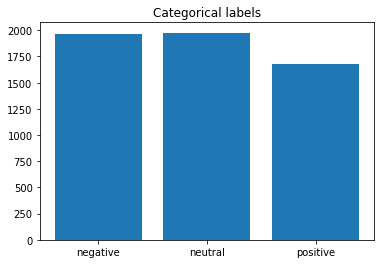

In [349]:
# Bar Chart for train_labels
labels = ['negative', 'neutral', 'positive']
values = pd.DataFrame(targets_oba).value_counts().sort_index()
plt.bar(labels, values)
plt.title('Categorical labels')
plt.show()

In [371]:
tweets_oba

array(['kirkpatrick wore baseb cap embroid barack obama signatur hangdog look jason segel courier journal',
       'obama debat cracker cracker tonight tune teamobama',
       'miss point im afraid understand bigger pictur dont care obama elect',
       ...,
       'reason ann romney michel obama match last night michel obama ann romney show last nig',
       'obama kenakan cincin syahadat sejak sma',
       'bitch like obama3 bitch want food stamp lmao'], dtype=object)

## WordCloud for Oba_Tweet

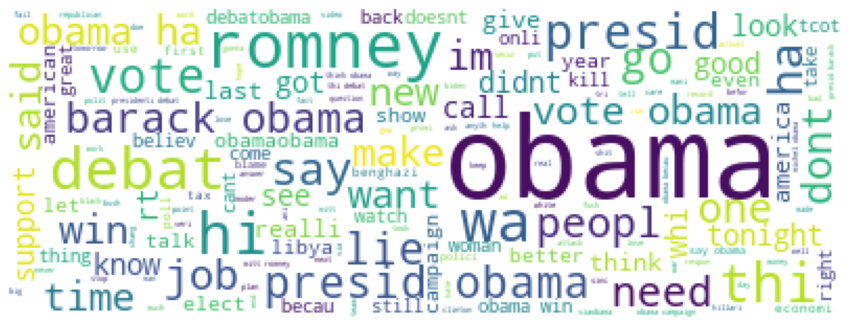

In [372]:
#Original Tweet
wordcloud(''.join(tweets_oba))

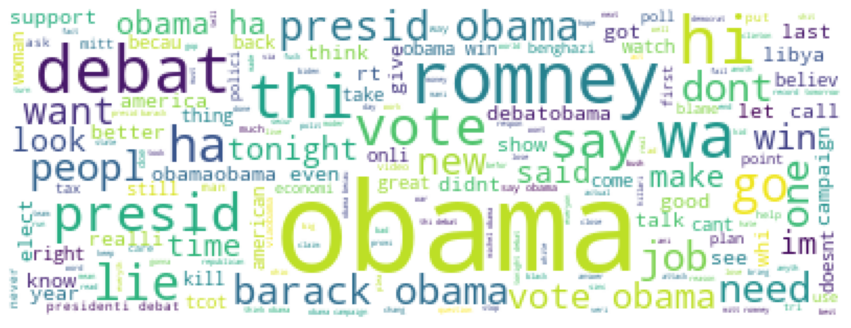

In [377]:
#Basic tweet cleaning
oba_reg = tweet_cleaning(tweets_oba, '')
wordcloud(''.join(oba_reg))

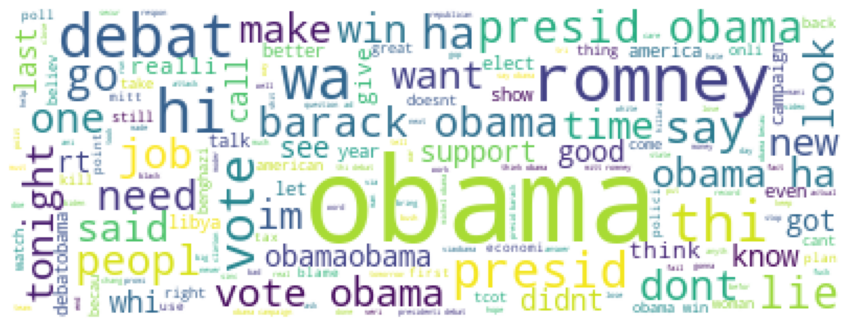

In [378]:
# Tweet stemmer_lemmatizer
oba_stemlem = tweet_cleaning(tweets_oba, 'stem_lem')
#print(oba_stemlem)
wordcloud(''.join(oba_stemlem))

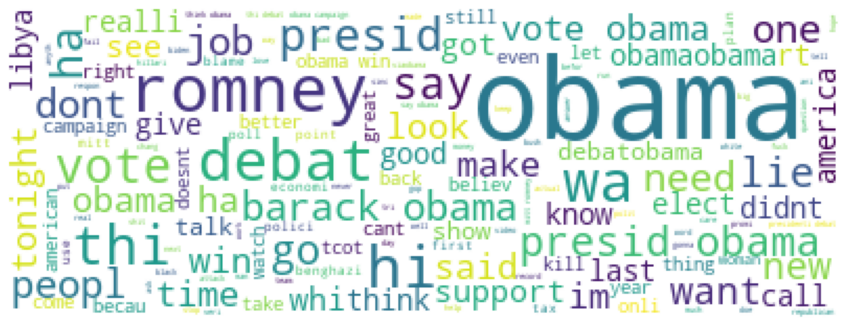

In [379]:
# Remove stopword
oba_rmstop = tweet_cleaning(tweets_oba, 'rm_stopwords')
#print(oba_rmstop)
wordcloud(''.join(oba_rmstop))

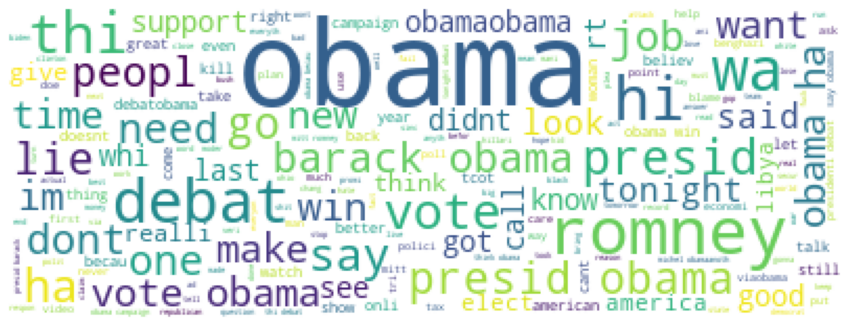

In [531]:
# All cleaning methods
oba_cleanall = tweet_cleaning(tweets_oba, 'all')
#print(oba_cleanall)
wordcloud(''.join(oba_cleanall))

In [138]:
save_dataset(oba_cleanall, targets_oba, 'tweets_oba', 'targets_oba')

Saving training dataset...
Saved parsed dataset


## Romney's Tweets

In [551]:
tweets_rom, targets_rom = data_parse(df2)
tweets_rom.shape, targets_rom.shape

(7200, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 1 to 7200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7200 non-null   object
 1   Class   7200 non-null   object
dtypes: object(2)
memory usage: 168.8+ KB
None
-1      2893
0       1680
2       1351
1       1075
!!!!     169
nan       29
IR         3
Name: Class, dtype: int64
After extracting: (5648, 2)


((5648,), (5648,))

In [552]:
pd.DataFrame(targets_rom).value_counts().sort_index()

-1    2893
0     1680
1     1075
dtype: int64

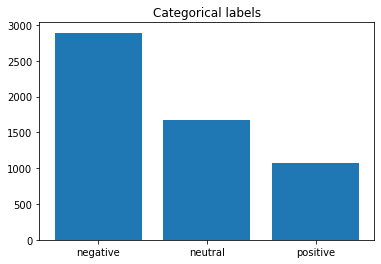

In [553]:
# Bar Chart for train_labels
labels = ['negative', 'neutral', 'positive']
values = pd.DataFrame(targets_rom).value_counts().sort_index()
plt.bar(labels, values)
plt.title('Categorical labels')
plt.show()

In [554]:
tweets_rom

array(["Insidious!<e>Mitt Romney</e>'s Bain Helped Philip Morris Get U.S. High Schoolers <a>Hooked On Cigarettes</a> http://t.co/nMKuFcUq via @HuffPostPol",
       '.@WardBrenda @shortwave8669 @allanbourdius you mean like <e>romney </e><a>cheated in primary</a>?',
       "<e>Mitt Romney</e> still doesn't <a>believe</a> that we <a>have a black president</a>.",
       ...,
       'el 59 por ciento de las mujeres blancas casadas respaldan a <e>Romney</e>"""',
       '"And they brought us a whole binder of women"""" oh <e>Romney</e>"""',
       '@FoxNews <e>Romney</e>won"""'], dtype=object)

## WordCloud for Rom_tweet

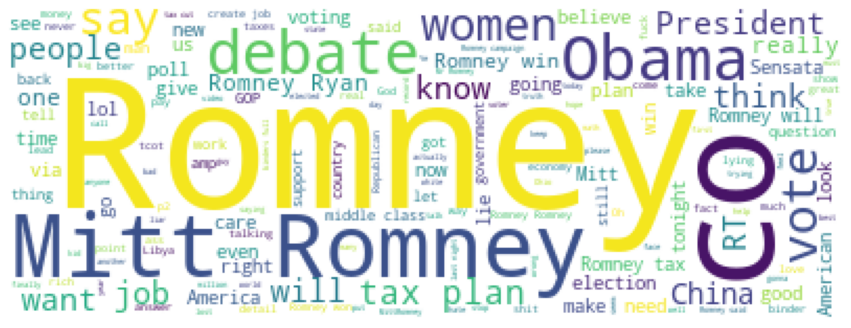

In [555]:
wordcloud(' '.join(tweets_rom))

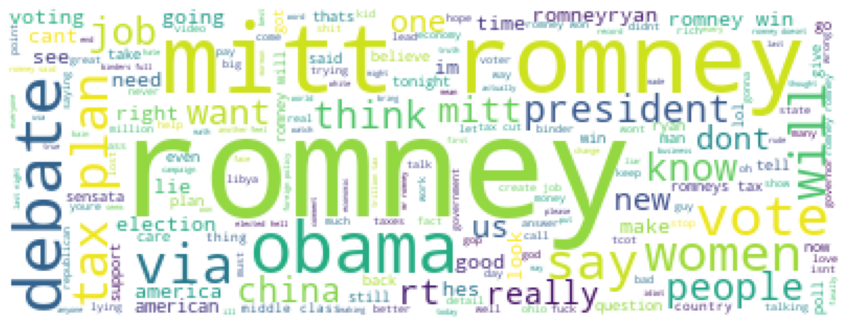

In [556]:
# Basic Tweet Cleaning
rom_reg = tweet_cleaning(tweets_rom, '')
#print(rom_rmspecial)
wordcloud(''.join(rom_reg))

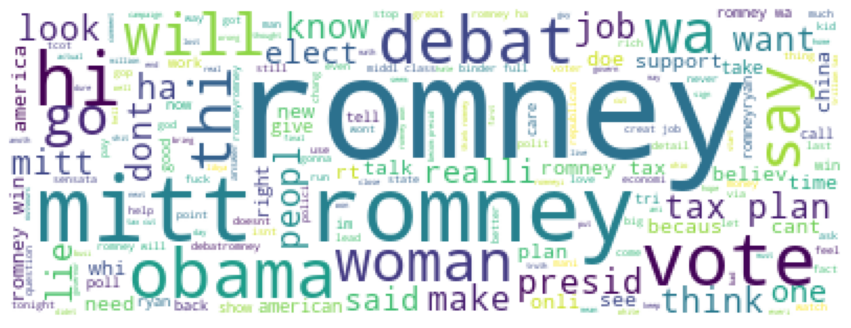

In [557]:
# Tweet stemmer_lemmatizer
rom_stemlem = tweet_cleaning(tweets_rom, 'stem_lem')
#print(rom_stemlem)
wordcloud(''.join(rom_stemlem))

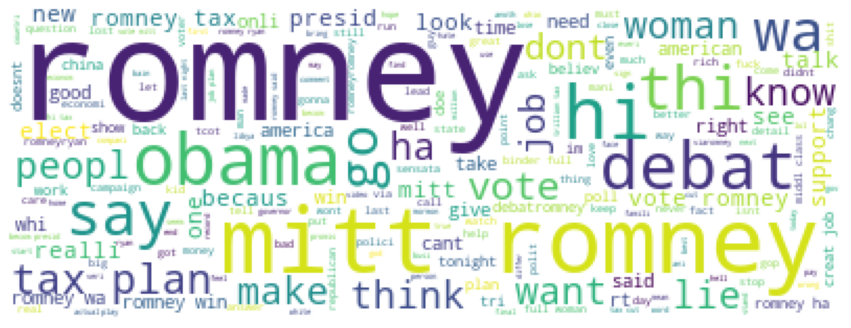

In [558]:
# Remove stopword
rom_rmstop = tweet_cleaning(tweets_rom, 'rm_stopwords')
#print(rom_rmstop)
wordcloud(''.join(rom_rmstop))

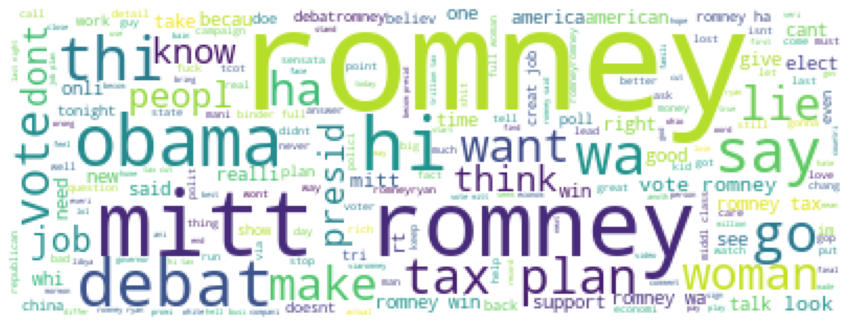

In [559]:
# All cleaning methods
rom_cleanall = tweet_cleaning(tweets_rom, 'all')
#print(rom_cleanall)
wordcloud(''.join(rom_cleanall))

In [560]:
save_dataset(rom_cleanall, targets_rom, 'tweets_rom', 'targets_rom')

Saving training dataset...
Saved parsed dataset


In [561]:
tmp = [tweets_rom, rom_reg, rom_stemlem, rom_rmstop]
tmp[0].shape

(5648,)

## Data Preparation

In [576]:
train_oba_X, test_oba_X, train_oba_Y, test_oba_Y = train_test_split(oba_cleanall, targets_oba, test_size = 0.2, random_state = 2018)
train_rom_X, test_rom_X, train_rom_Y, test_rom_Y = train_test_split(rom_cleanall, targets_rom, test_size = 0.2, random_state = 2018)

In [563]:
data_all = np.concatenate((oba_cleanall, rom_cleanall))
target_all = np.concatenate((targets_oba, targets_rom))
data_all.shape, target_all.shape

((11272,), (11272,))

In [564]:
data_all[0], target_all[0]

('kirkpatrick wore baseb cap embroid barack obama signatur hangdog look jason segel courier journal',
 '0')

In [565]:
import random
tmp = list(zip(data_all, target_all))
random.shuffle(tmp)
data_all, target_all = zip(*tmp)
data_all[0], target_all[0]

('cat call sexist im vote romney becau dick', '-1')

In [566]:
train_X, test_X, train_Y, test_Y = train_test_split(data_all, target_all, test_size = 0.2, random_state = 2018)

## Data Vectorization

### TF-IDF vectorizer

In [416]:
def tfidfvec(train_X, test_X):
    tfv = TfidfVectorizer(analyzer='word', min_df= 3)
    train_tfv = tfv.fit_transform(train_X)
    test_tfv = tfv.transform(test_X)
    
    #Print tfidfvec result
    vocab = tfv.get_feature_names()
    print(vocab[:5])
    print("Vocabulary length:", len(vocab))
    dist = np.sum(train_tfv, axis=0)
    checking = pd.DataFrame(dist, columns = vocab)
    display(checking)
    
    return train_tfv, test_tfv

In [529]:
#train_oba_X, test_oba_X = tfidfvec(train_oba_X, test_oba_X)

['abc', 'abl', 'abort', 'absolut', 'abt']
Vocabulary length: 1930


,abc,abl,abort,absolut,abt,accept,accomplish,accord,account,accu,...,yo,york,youd,youll,young,youth,youtub,youv,yr,zero
0,6.443901,2.514776,2.77467,8.32547,3.000353,2.100865,4.094825,1.328386,4.508848,3.575373,...,5.024886,3.315182,1.716562,3.282506,2.46986,1.151794,4.320831,1.562696,5.360147,1.83104


In [418]:
#train_rom_X, test_rom_X = tfidfvec(train_rom_X, test_rom_X)

['abc', 'abl', 'abort', 'abov', 'absolut']
Vocabulary length: 1883


,abc,abl,abort,abov,absolut,absurd,abt,accept,accomplish,accord,...,yesterday,yet,yo,york,youd,youll,young,youv,yr,zero
0,2.329979,4.720998,6.301298,1.278176,3.199109,1.489842,3.127,1.785181,1.421209,4.260113,...,1.389601,6.441987,2.437065,4.530033,1.443986,2.98617,2.256131,1.221306,3.329794,2.415199


In [419]:
#train_both_X, test_both_X = tfidfvec(train_X, test_X)

['abc', 'abl', 'abort', 'abov', 'absent']
Vocabulary length: 2923


,abc,abl,abort,abov,absent,absolut,absurd,abt,abu,accept,...,youll,young,younger,youth,youtub,youtubepolit,youv,yr,zero,zogbi
0,7.526101,7.701263,9.046116,2.153639,1.288644,11.591177,2.297425,4.993938,1.98295,3.023886,...,6.564746,5.323624,1.305795,1.196221,2.849007,1.601944,3.511856,9.684802,2.827478,1.461719


### Count Vector

In [235]:
#cv = CountVectorizer()
cv = CountVectorizer(token_pattern='(?u)\\b\\w+\\b',min_df=3,max_df=0.8) 
# min_df=3 means "ignore terms that appear in less than 3 documents"
# max_df=0.8 means "ignore terms that appear in more than 80% of the documents"
train_cv = cv.fit_transform(train_X)
test_cv = cv.transform(test_X)

In [236]:
cvocab = cv.get_feature_names()
print(cvocab[:5])

['0', '08', '1', '10', '100']


In [588]:
def plot_cm(test_Y, pred_Y):
    cont_matrix = confusion_matrix(test_Y, pred_Y)
    sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    

## Train Models

### I. SVC

In [590]:
def define_pipe(model):
    pipe = Pipeline([('vect', CountVectorizer(min_df=3, max_df=0.8)), 
                 ('tfidf', TfidfTransformer()),  
                 ('model', model)])
    return pipe

              precision    recall  f1-score   support

          -1       0.90      0.88      0.89       409
           0       0.86      0.85      0.85       401
           1       0.84      0.88      0.86       315

    accuracy                           0.87      1125
   macro avg       0.87      0.87      0.87      1125
weighted avg       0.87      0.87      0.87      1125



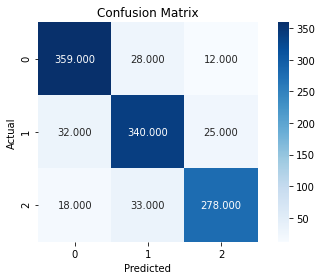

In [598]:
# SVC with obama's tweets
pipe_SVC = define_pipe(SVC())
pipe_SVC.fit(train_oba_X, train_oba_Y)
y_pred = pipe.predict(test_oba_X)

print(classification_report(y_pred, test_oba_Y))
plot_cm(test_oba_Y, y_pred)

              precision    recall  f1-score   support

          -1       0.28      0.65      0.39       251
           0       0.72      0.32      0.45       724
           1       0.30      0.44      0.36       155

    accuracy                           0.41      1130
   macro avg       0.43      0.47      0.40      1130
weighted avg       0.57      0.41      0.42      1130



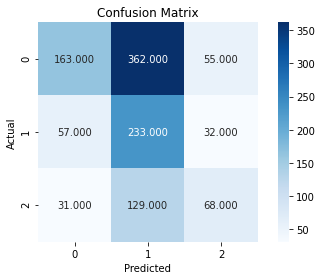

In [597]:
# SVC with romney's tweets
pipe_SVC = define_pipe(SVC())
pipe_SVC.fit(train_rom_X, train_rom_Y)
y_pred = pipe.predict(test_rom_X)
print(classification_report(y_pred, test_rom_Y))
plot_cm(test_rom_Y, y_pred)

              precision    recall  f1-score   support

          -1       0.53      0.77      0.63       663
           0       0.80      0.53      0.64      1113
           1       0.63      0.71      0.67       479

    accuracy                           0.64      2255
   macro avg       0.65      0.67      0.64      2255
weighted avg       0.68      0.64      0.64      2255



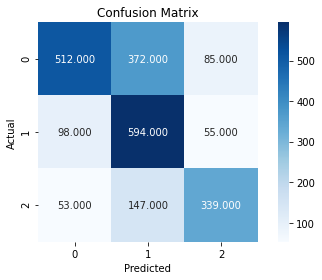

In [596]:
#SVC with both rom and oba's tweets
pipe_SVC = define_pipe(SVC())
pipe_SVC.fit(train_X, train_Y)
y_pred = pipe.predict(test_X)
print(classification_report(y_pred,test_Y))
plot_cm(test_Y, y_pred)

### II. MLPClassifier

In [176]:
MLP = MLPClassifier(random_state = 42)

mlp_param_grid = {
    'hidden_layer_sizes':[(5)],
    'activation':['relu'],
    'solver':['adam'],
    'alpha':[0.3],
    'learning_rate':['constant'],
    'max_iter':[1000]
}


gsMLP = GridSearchCV(MLP, param_grid = mlp_param_grid, cv = kfold, n_jobs= 1, verbose = 1)
gsMLP.fit(train_tfv, train_Y)
print(gsMLP.best_params_)
mlp_best0 = gsMLP.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.9s finished


{'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': 5, 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}


In [177]:
gsMLP.best_score_

0.550347793845013

### III. LogisticRegression

In [420]:
from sklearn import linear_model

logisticReg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000)
logisticReg.fit(train_oba_X, train_oba_Y)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [422]:
Y_predict=logisticReg.predict(test_oba_X)

In [423]:
print(classification_report(Y_predict,test_oba_Y))

              precision    recall  f1-score   support

          -1       0.62      0.57      0.59       416
           0       0.51      0.54      0.53       368
           1       0.59      0.60      0.59       341

    accuracy                           0.57      1125
   macro avg       0.57      0.57      0.57      1125
weighted avg       0.57      0.57      0.57      1125



In [424]:
logisticReg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000)
logisticReg.fit(train_rom_X, train_rom_Y)
Y_predict=logisticReg.predict(test_rom_X)
print(classification_report(Y_predict, test_rom_Y))

              precision    recall  f1-score   support

          -1       0.60      0.74      0.66       476
           0       0.49      0.41      0.45       360
           1       0.57      0.47      0.52       294

    accuracy                           0.57      1130
   macro avg       0.56      0.54      0.54      1130
weighted avg       0.56      0.57      0.56      1130



In [425]:
from sklearn import svm
clf = svm.LinearSVC(max_iter=2000)
clf.fit(train_both_X, train_Y)

LinearSVC(max_iter=2000)

In [426]:
Y_predict=clf.predict(test_both_X)
print(classification_report(Y_predict,test_Y))

              precision    recall  f1-score   support

          -1       0.69      0.60      0.65      1129
           0       0.42      0.50      0.46       624
           1       0.48      0.51      0.49       502

    accuracy                           0.55      2255
   macro avg       0.53      0.54      0.53      2255
weighted avg       0.57      0.55      0.56      2255



In [427]:
clf = svm.LinearSVC(max_iter=2000)
clf.fit(train_oba_X, train_oba_Y)
Y_predict=clf.predict(test_oba_X)
print(classification_report(Y_predict, test_oba_Y))

              precision    recall  f1-score   support

          -1       0.63      0.56      0.59       434
           0       0.48      0.53      0.50       353
           1       0.57      0.58      0.57       338

    accuracy                           0.56      1125
   macro avg       0.56      0.56      0.56      1125
weighted avg       0.56      0.56      0.56      1125



### IV. Random Forest

In [305]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

Training Accuracy : 0.9851078017337186
Validation Accuracy : 0.5608888888888889
[[222 113  53]
 [ 94 227  71]
 [ 58 105 182]]


In [307]:
model = RandomForestClassifier()
model.fit(train_rtfv, train_rom_Y)

y_pred = model.predict(test_rtfv)

print("Training Accuracy :", model.score(train_rtfv, train_rom_Y))
print("Validation Accuracy :", model.score(test_rtfv, test_rom_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_rom_Y, y_pred)
print(cm)
print(classification_report(y_pred, test_rom_Y))

Training Accuracy : 0.9860557768924303
Validation Accuracy : 0.5761061946902655
[[489  78  17]
 [188  96  20]
 [136  40  66]]
              precision    recall  f1-score   support

          -1       0.84      0.60      0.70       813
           0       0.32      0.45      0.37       214
           1       0.27      0.64      0.38       103

    accuracy                           0.58      1130
   macro avg       0.48      0.56      0.48      1130
weighted avg       0.69      0.58      0.61      1130



In [273]:
model = DecisionTreeClassifier()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

Training Accuracy : 0.9851078017337186
Validation Accuracy : 0.48533333333333334
[[186 130  72]
 [106 186 100]
 [ 72  99 174]]


In [275]:
kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )
sv = LinearSVC(random_state=2018)

param_grid2 = {
    'loss':['squared_hinge'],
    'class_weight':[{1:4}],
    'C': [0.2]
}
sv.fit(train_tfv, train_Y)
accuracy_scbore(test_Y, sv.predict(test_tfv))

0.5573333333333333

### V. Naive Bayes

In [500]:
vect = CountVectorizer(min_df=3, ngram_range=(1, 2))
# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(train_X)
X_test_dtm = vect.transform(test_X)

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_test_dtm)

<1125x3515 sparse matrix of type '<class 'numpy.float64'>'
	with 10727 stored elements in Compressed Sparse Row format>

In [501]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
gnb = GaussianNB()
mtnb = MultinomialNB()
#Y_pred_Bayes = gnb.fit(train_tfv.toarray(), train_Y).predict(test_tfv.toarray())
Y_pred_Bayes = mtnb.fit(X_train_dtm.toarray(), train_Y).predict(X_test_dtm.toarray())

In [503]:
print('MultinomialNB')
print(classification_report(Y_pred_Bayes,test_Y))

MultinomialNB
              precision    recall  f1-score   support

          -1       0.65      0.63      0.64       422
           0       0.54      0.58      0.56       361
           1       0.62      0.60      0.61       342

    accuracy                           0.60      1125
   macro avg       0.60      0.60      0.60      1125
weighted avg       0.61      0.60      0.60      1125



In [280]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(train_tfv, train_Y)

In [286]:
clf.best_params_, clf.best_score_

({'C': 1000.0, 'gamma': 0.0005}, 0.5776813743665801, 1)

In [282]:
Y_predict=clf.predict(test_tfv)
print(classification_report(Y_predict,test_Y))

              precision    recall  f1-score   support

          -1       0.63      0.56      0.59       439
           0       0.52      0.53      0.53       387
           1       0.53      0.62      0.57       299

    accuracy                           0.56      1125
   macro avg       0.56      0.57      0.56      1125
weighted avg       0.57      0.56      0.56      1125



In [ ]:
#Ensemble models
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())